In [20]:
%reset

In [4]:
# Code for calculating powder mass flow from offline weigh data
# Created: 06-14-2024
# Modified: 05-23-2024

# Analysis for DATE DATE DATE

import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import importlib
from pathlib import Path
import scipy.signal
from tbcontrol.responses import fopdt, sopdt


from track_functions import *
import track_functions
powder_functions = importlib.reload(track_functions)

# Copy + paste files to analyze in data
# Set variables (RPM and step time) based on experimental parameters
# Run program
# Ideally, plot exported csv files in R


# Variables

In [5]:
# IF ANALYZING MORE THAN 1 DATASET, ***EXPERIMENTAL VARIABLES MUST BE THE SAME***
# Range of RPMs and time steps must be equal

# Folder name for exported files
experimentID = "IN718 Bead Height"


# List range of RPMs tested
RPM = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

# See getMassFlow step
"""# Designate start and end times for RPM changes
# Experiment start deposition, end deposition, time period at a single RPM
start_time = np.arange(10, 100, 20)
end_time = np.arange(20, 110, 20)"""

'# Designate start and end times for RPM changes\n# Experiment start deposition, end deposition, time period at a single RPM\nstart_time = np.arange(10, 100, 20)\nend_time = np.arange(20, 110, 20)'

# Import Data

In [6]:
csv = [os.path.splitext(file)[0] for file in os.listdir("data/") if file.endswith('.txt')]
print(csv)

importData = {}
data = {}

for file in csv:
    filepath = os.path.join("data/", file + ".txt")
    #importData[file] = pd.read_csv(filepath, sep="  ")
    #importData[file] = pd.read_fwf(filepath)
    importData[file] = pd.read_csv(filepath, skiprows=3, sep='\s+')
    filename = file.replace('.txt', '')

print(importData)

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\faith\AppData\Local\Temp\ipykernel_57036\1196492735.py:11: SyntaxWarning: invalid escape sequence '\s'
  importData[file] = pd.read_csv(filepath, skiprows=3, sep='\s+')


['exp1_IN718 1RPM_off-on', 'exp2_IN718 2RPM_off-on', 'exp3_IN718 1RPM_on-off', 'exp4_IN718 2RPM_on-off']
{'exp1_IN718 1RPM_off-on':               0  0.00010510524
0      0.000007       0.000105
1      0.000013       0.000105
2      0.000020       0.000105
3      0.000026       0.000105
4      0.000033       0.000105
...         ...            ...
12454  0.081516      -0.000008
12455  0.081523      -0.000008
12456  0.081529      -0.000008
12457  0.081536      -0.000008
12458  0.081543      -0.000008

[12459 rows x 2 columns], 'exp2_IN718 2RPM_off-on':               0  -1.5241477e-06
0      0.000007   -1.473261e-06
1      0.000013   -1.322620e-06
2      0.000020   -1.061648e-06
3      0.000026   -7.019818e-07
4      0.000033   -3.080304e-07
...         ...             ...
12512  0.081900   -5.513316e-06
12513  0.081907   -5.366980e-06
12514  0.081913   -5.229137e-06
12515  0.081920   -5.101973e-06
12516  0.081927   -4.971723e-06

[12517 rows x 2 columns], 'exp3_IN718 1RPM_on-off':       

# Clean Data

In [7]:
clean_data = {}
clean_with_delay = {}
delay = {}

# Input an overestimate of the delay row index
# Used to find largest change in initial values (experiment start)
overestimate_delay = 5000

for file in csv:
    clean_data[file], clean_with_delay[file], delay[file] = cleanData(importData[file], overestimate_delay)

print(clean_data)
print(clean_with_delay)
print(delay)

Track begins at row index 4898
The delay is 32.063334999999995 mm

Track begins at row index 4865
The delay is 31.849039 mm

Track begins at row index 1637
The delay is 4.274299 mm

Track begins at row index 4015
The delay is 10.479334999999999 mm

{'exp1_IN718 1RPM_off-on':             Time    Height
4898    0.000000  0.000000
4899    0.006545  0.008840
4900    0.013090  0.016053
4901    0.019635  0.019097
4902    0.026180  0.017930
...          ...       ...
12454  49.453064 -0.486250
12455  49.459609 -0.486183
12456  49.466154 -0.486124
12457  49.472699 -0.486096
12458  49.479243 -0.486063

[7561 rows x 2 columns], 'exp2_IN718 2RPM_off-on':             Time    Height
4865    0.000000  0.000000
4866    0.006546  0.010670
4867    0.013091  0.020370
4868    0.019636  0.028249
4869    0.026181  0.033979
...          ...       ...
12512  50.051296 -1.000895
12513  50.057841 -1.000748
12514  50.064387 -1.000610
12515  50.070932 -1.000483
12516  50.077477 -1.000353

[7652 rows x 2 columns]

C:\Users\faith\OneDrive - NU\Documents\_2 RESEARCH\2.19 Analysis Scripts\arpi_powder_flow\track_functions.py:71: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Height'][data['Height'] < -0.05] = -0.05
C:\Users\faith\OneDrive - NU\Docume


# Calculate Steady State Mass Flow

In [ ]:
mass_flow = {}

# Designate start and end times for RPM changes
# Experiment start deposition, end deposition, time period at a single RPM
start_time = np.arange(10, 110, 20)
end_time = np.arange(30, 130, 20)

for file in csv:
    mass_flow[file] = getSteadyMassFlow(clean_data[file], RPM, start_time, end_time)

print(mass_flow)


# Summarize Data

In [692]:
#for file in csv:
summary = pd.concat([pd.DataFrame(mass_flow[file], columns=['Mass Flow [g/min]']) for file in csv], axis=1, ignore_index=True)
summary.columns = csv
summary.insert(0, "RPM", RPM)
summary.to_csv(os.path.join(export_path, "SUMMARY_" + experimentID + ".csv"), index=False)
print(export_path)

print(summary)

export\(230123) PML Nb 0.1-0.3RPM 5LPM
   RPM  (230123) Powder Flow Measurement_Nb_5LPM
0  0.1                                  0.817092
1  0.2                                  1.190523
2  0.3                                  2.503614


# Filter Data

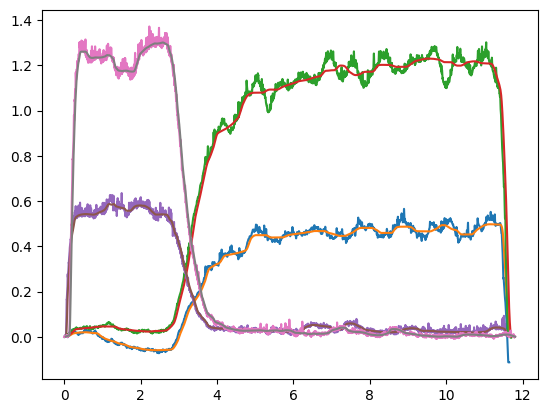

In [8]:
dwell = 10
filtered_data = {}


for file in csv:
    #gradient_data = gradient(clean_with_delay[file], dwell)
    plt.plot(clean_with_delay[file]['Time']/7, clean_with_delay[file]['Height'])
    #plt.plot(clean_data[file]['Time'], clean_data[file]['Height'])

    filtered_data[file] = pd.DataFrame(columns=['Time','Input','Height'])

    filtered_data[file]['Time'] = clean_with_delay[file]['Time']/7
    median_filt = scipy.signal.medfilt(clean_with_delay[file]['Height'], kernel_size=801)
    median_df = pd.DataFrame(median_filt)
    #gradient_data['Mdot'] = np.ma.average(mdot_median_filt, axis=None, weights=None, returned=False)
    filtered_data[file]['Height'] = median_df.rolling(100).mean()
    #gradient_data.dropna(inplace=True)"""
    filtered_data[file]['Height'].dropna(inplace=True)

    filtered_data[file]['Input'] = np.where(filtered_data[file]['Time'].gt(dwell/7), 1, 0)

    plt.plot(filtered_data[file]['Time'], filtered_data[file]['Height'])



# Save Data

In [228]:
export_path = os.path.join("export", experimentID)

# Make a folder in export to save procesed files
if not os.path.exists(export_path):
    os.makedirs(export_path)

for file in csv:
    #clean_data[file].to_csv(os.path.join(export_path, file + "_CLEAN.csv"), index=False)
    filtered_data[file].to_csv(os.path.join(export_path, file + "_CLEAN_WITH_DELAY.csv"), index=False)
    #mass_flow[file].to_csv(os.path.join(export_path, file + "_MASSFLOW.csv"), index=False)

# Make a folder in archive to move raw files
if not os.path.exists(os.path.join("data/archive/", experimentID)):
    os.makedirs(os.path.join("data/archive/", experimentID))


# Fit First Order Model

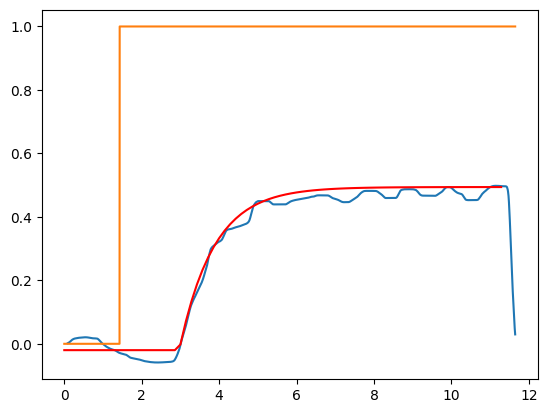

           0
0  -0.020000
1  -0.020000
2  -0.020000
3  -0.020000
4  -0.020000
..       ...
75  0.493915
76  0.493927
77  0.493938
78  0.493947
79  0.493955

[80 rows x 1 columns]


In [33]:


"""dwell = 0.1

for file in csv:
    gradient_data = gradient(clean_with_delay[file], dwell)
    plt.plot(clean_with_delay[file]['Time'], clean_with_delay[file]['Height'])
print(gradient_data)"""

#plt.plot(gradient_data['Time'], gradient_data['Mdot'])
#plt.plot(gradient_data['Time'], gradient_data['Input'])
#plt.ylim([-0.1,0.5])

export_path = os.path.join("export", experimentID)

K=0.514
tau=0.89
y0=-0.02
x0=10/7
theta=1.54+x0
time_domain = np.arange(0, 80, 1)/7

file = 'exp1_IN718 1RPM_off-on'

#num = k*np.exp(theta*range)

#w,h = scipy.signal.freqs(K, [tau, 1])

def resultplot(K, tau, theta, y0):
    #plt.scatter(ts, ym)
    fitted_curve = fopdt(time_domain, K, tau, theta, y0)
    plt.plot(time_domain, fitted_curve, color='red')
    plt.show()
    return fitted_curve

plt.plot(filtered_data[file]['Time'], filtered_data[file]['Height'])
plt.plot(filtered_data[file]['Time'], filtered_data[file]['Input'])
fitted_curve = resultplot(K,tau,theta,y0)
fitted_curve = pd.DataFrame(fitted_curve)

print(fitted_curve)

#fitted_curve.to_csv(os.path.join(export_path, file + "_FOPDT.csv"), index=False)




TypeError: fopdt() missing 1 required positional argument: 'thetam'

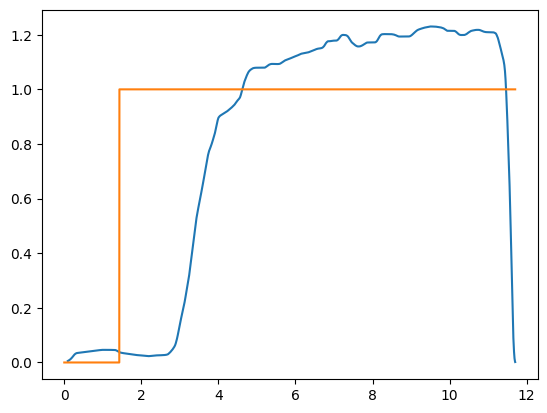

In [50]:
export_path = os.path.join("export", experimentID)

K=0.514
tau=0.89
y0=-0.02
x0=10/7
thetam=1.54+x0
time_domain = np.arange(0, 80, 1)/7

file = 'exp2_IN718 2RPM_off-on'

#num = k*np.exp(theta*range)

#w,h = scipy.signal.freqs(K, [tau, 1])

def resultplot(K, tau, theta, y0):
    #plt.scatter(ts, ym)
    fitted_curve = fopdt(time_domain, K, tau, thetam, y0)
    plt.plot(time_domain, fitted_curve, color='red')
    plt.show()
    return fitted_curve

plt.plot(filtered_data[file]['Time'], filtered_data[file]['Height'])
plt.plot(filtered_data[file]['Time'], filtered_data[file]['Input'])
fitted_curve = resultplot(K,tau,thetam,y0)
fitted_curve = pd.DataFrame(fitted_curve)

print(fitted_curve)

#fitted_curve.to_csv(os.path.join(export_path, file + "_FOPDT.csv"), index=False)

In [43]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

file = 'exp1_IN718 1RPM_off-on'


dataz = filtered_data[file]

t = dataz['Time'].values - dataz['Time'].values[0]
u = dataz['Input'].values
yp = dataz['Height'].values
u0 = u[0]
yp0 = yp[0]



# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)



# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2    
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 1.0 # Km
x0[1] = 0.5 # taum
x0[2] = 1.5 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
solution = minimize(objective,x0)

print(solution)

C:\Users\faith\AppData\Local\Temp\ipykernel_57036\1845248950.py:62: ODEintWarning: Run terminated (internal error). Run with full_output = 1 to get quantitative information.
  y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
C:\Users\faith\AppData\Local\Temp\ipykernel_57036\1845248950.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ym[i+1] = y1[-1]


Initial SSE Objective: nan
  message: NaN result encountered.
  success: False
   status: 3
      fun: nan
        x: [ 1.000e+00  5.000e-01  1.500e+00]
      nit: 0
      jac: [       nan        nan        nan]
 hess_inv: [[1 0 0]
            [0 1 0]
            [0 0 1]]
     nfev: 4
     njev: 1


interactive(children=(FloatSlider(value=-0.5325, description='K', max=10.0, min=-10.0, step=0.01), FloatSlider…

<function __main__.fopdtPlot(K, tau, theta)>

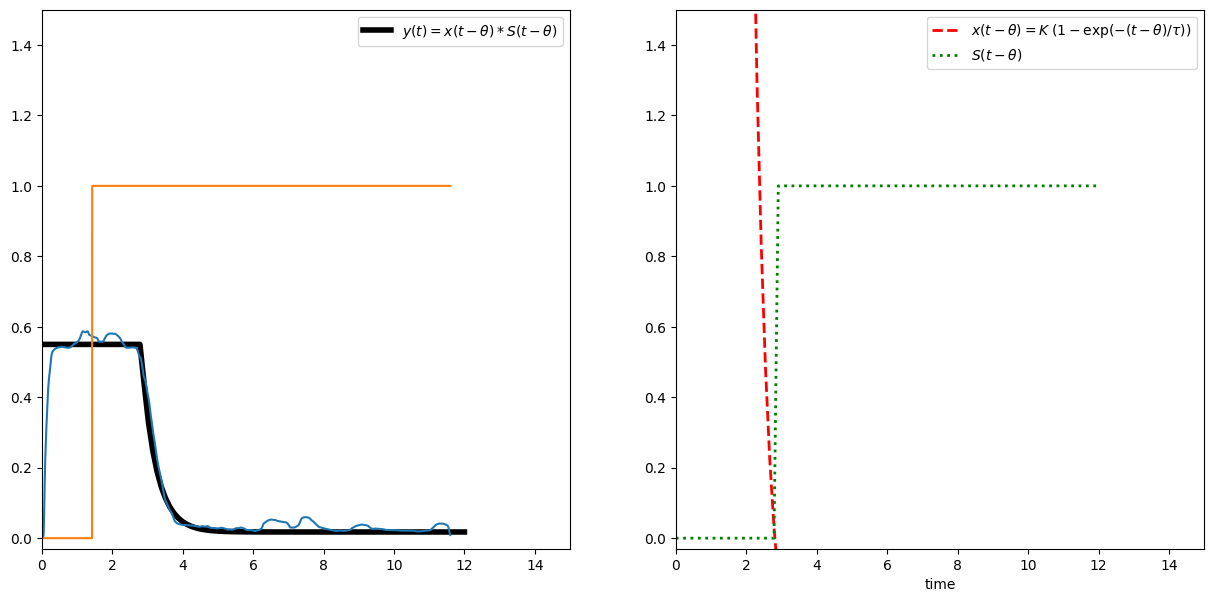

In [129]:
import ipywidgets as wg
from IPython.display import display 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt



file = 'exp3_IN718 1RPM_on-off'

def fopdtPlot(K,tau,theta):
    n = 100 # time points to plot
    t = np.linspace(0,12,100) # create time vector
    # create 0 -> 1 step at t=theta
    delay = np.empty_like(t)
    for i in range(n):
        if t[i] < theta:
            delay[i] = 0.0
        else:
            delay[i] = 1.0
    # calculate response to step input
    x = K * (1.0-np.exp(-(t-theta)/tau))
    y = x * delay + 0.55
    new_t = pd.DataFrame(t)
    new_y = pd.DataFrame(y)
    new_data = pd.concat([new_t,new_y], axis=1, ignore_index=True)
    # plot response
    plt.figure(1,figsize=(15,7))
    plt.subplot(1,2,1)
    plt.plot(t,y,'k-',linewidth=4,label=r'$y(t)=x(t-\theta)*S(t-\theta)$')
    plt.legend(loc='best')
    plt.plot(filtered_data[file]['Time'], filtered_data[file]['Height'])
    plt.plot(filtered_data[file]['Time'], filtered_data[file]['Input'])
    plt.ylim([-0.03,1.5])
    plt.xlim([0,15])
    plt.subplot(1,2,2)
    plt.plot(t,x,'r--',linewidth=2,label=r'$x(t-\theta)=K\;(1-\exp(-(t-\theta)/\tau))$')
    plt.plot(t,delay,'g:',linewidth=2,label=r'$S(t-\theta)$')
    plt.xlabel('time')
    plt.legend(loc='best')
    plt.ylim([-0.03,1.5])
    plt.xlim([0,15])
    new_data.to_csv(os.path.join(export_path, file + "_FOPDT.csv"), index=False)


K_slide = wg.FloatSlider(value=-0.5325,min=-10.0,max=10.0,step=0.01)
tau_slide = wg.FloatSlider(value=0.41,min=0.1,max=10.0,step=0.1)
theta_slide = wg.FloatSlider(value=2.81,min=0.1,max=15.0,step=0.1)
wg.interact(fopdtPlot, K=K_slide, tau=tau_slide, theta=theta_slide)


